In [1]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
PARAGRAPH_SKEWED = "data/ParagraphSkew.png"
PARAGRAPH_SKEWED2 = "data/ParagraphSkew2.png"

# Helper Methods

In [3]:
def show_image_at_path(path, name="Image"):
    img = cv2.imread(path)
    #cv2.imshow(name, img)
    #cv2.waitKey(0) 
    #cv2.destroyAllWindows()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def show_image_color(img, name="image"):
    #cv2.imshow(name, img)
    #cv2.waitKey(0) 
    #cv2.destroyAllWindows()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
def show_image_gray(img, name="image"):
    #cv2.imshow(name, img)
    #cv2.waitKey(0) 
    #cv2.destroyAllWindows()
    plt.imshow(img, cmap='gray')

def get_image(path):
    img = cv2.imread(path)
    return img

In [4]:
def get_elliptic_kernel(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

# Preprocessor

In [5]:
def preprocess(
    img, 
    denoise_intensity=10, 
    denoise_iters=10, 
    threshold=150, 
    threshold_max=255,
    thicken=True,
    isBlackBack=False,
    thickenKernel=2,
):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray,None,denoise_intensity)
    for i in range(denoise_iters):
        denoised = cv2.fastNlMeansDenoising(denoised,None,denoise_intensity)
    thresh, gray_threshold = cv2.threshold(denoised, threshold, threshold_max, cv2.THRESH_BINARY)
    if not thicken:
        return gray_threshold
    if isBlackBack : 
        thickened = cv2.dilate(gray_threshold, get_elliptic_kernel(thickenKernel))
    else :
        thickened = cv2.erode(gray_threshold, get_elliptic_kernel(thickenKernel))
    return thickened

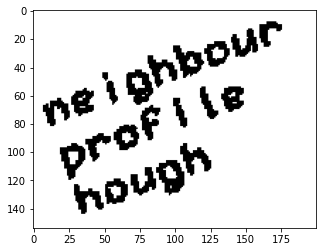

In [6]:
img = get_image(PARAGRAPH_SKEWED2)
img2 = preprocess(img)
show_image_gray(img2)

# Main Algorithm

In [7]:
def getLefts(img, blackBackground = False, depth_ratio = 1, depth_absolute = 50):
    arr = []
    limit = min(depth_ratio*img.shape[1], depth_absolute)
    for i in range(img.shape[0]):
        for j in range(limit):
            if blackBackground and img[i][j]==1:
                    arr.append(j)
                    break
            if not blackBackground and img[i][j]==0:
                    arr.append(j)
                    break
    return arr

def getDirection(arr, ratio = 0.1, tolerance = 0.1):
    l = len(arr)
    
    mn = arr[0]
    ind = 0
    for i in range(l):
        if arr[i]<mn:
            mn = arr[i]
            ind = i
    direction = sum(lefts[:ind])-sum(lefts[ind:])
    
    # head is left
    if direction<=0:
        height = arr[-1] - mn
        base = l - ind
        angle = math.atan(height/base)
        return -1*angle*57.296
    
    # head is right
    height = arr[-1] - mn
    base = ind
    angle = math.atan(height/base)
    return angle*57.296

def rotate_image(image, angle, blackBackground=False):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    
    if blackBackground :
        result = cv2.warpAffine(
            image, 
            rot_mat, 
            image.shape[1::-1], 
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue = (0,0,0)
        )
    else :
        result = cv2.warpAffine(
            image, 
            rot_mat, 
            image.shape[1::-1], 
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue = (255,255, 255)
        )
    return result

In [8]:
lefts = getLefts(img2)
angle = getDirection(lefts)
print("Angle (deg) :", angle)

Angle (deg) : -21.370704508256296


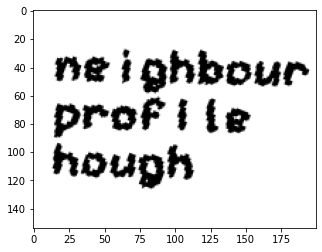

In [9]:
fixedImage = rotate_image(img2, angle)
show_image_gray(fixedImage)

### Test 2

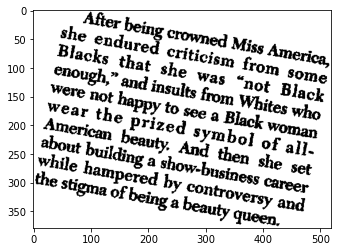

In [11]:
img = get_image(PARAGRAPH_SKEWED)
img2 = preprocess(img)
show_image_gray(img2)

Angle (deg) : 15.080849345685515


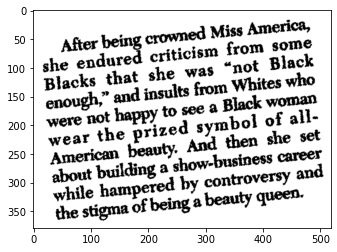

In [13]:
lefts = getLefts(img2)
angle = getDirection(lefts)
print("Angle (deg) :", angle)
fixedImage = rotate_image(img2, angle)
show_image_gray(fixedImage)